# ML preproc

> Preprocessing of a multi-class EEG familiarity prediction problem

In [1]:
#| default_exp preproc

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import scipy
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
#| export
# wrapper class for data preprocessing
class preproc:
    """
    Preprocessing package that preprocess the
    given the features in multi class settings,
    get out the desire class.
    """
    
    # class attributes
    source_info = ["SC", "CR", "SI", "M", "FA"]
    response_info = ["RS", "RO", "F", "MN", "SN"]
    
    def __init__(self, file_path, experiment_num):
        """
        Initialize the Preprocessing module and load the appropriate dataset
        
        Parameters
        ----------
        file_path : str
            file path to the matlab matrix data
        experiment_num : int
            denotes the experiement number

        """
        data = scipy.io.loadmat(file_path)
        # user trail order
        self.tr_order = data[f'user_tr_order_{experiment_num}'][0]

        # projection scores
        self.proj_score = data[f'user_prob_{experiment_num}'][0]

        # source and response label
        self.source_label = data[f'user_source_{experiment_num}'][0]
        self.resp_label = data[f'user_resp_{experiment_num}'][0]

        # features, group the channels and average over the windows,
        # those are called features, and we use the features for training
        self.behav_feat = data[f'user_feat_{experiment_num}'][0]
        
        self.data = data

        subjects = []

        # use tr_order to label with participant with an identifier
        for subject, tr in enumerate(self.tr_order):
            subjects.append(np.repeat(subject, len(tr)))

        self.subject = np.concatenate(subjects)

        # keep track of the subject that we kept out because they did not
        # meet certain criteria. In this case, is the participant with less
        # than 10 observations on the pos or neg class.
        self.left_out_subject = []

    
    def filter_index(self, pos_source_label: int, pos_resp_label: int,
                           neg_source_label: int, neg_resp_label: int):
        """
        A simplified version of prepare label. Instead of returns all the
        dataset (X, y, group), this only returns a boolean array of the corresponding index
        Since the data is in a nested array (in other words, 2-d array with different dim),
        the returned element should also be a nested array.
        
        The purpose of this is to prepared for multi-subclass merge for a single class preparation
        
        Parameters
        ----------
        pos_source_label : int
            the positive class's source label.
            for details, please refer to the above encodings
        pos_resp_label : int
            the positive class's response label
        neg_source_label : int
            the negative class's source label
        neg_response_label : int
            the negative class's response label

        Returns
        -------
        pos_idx : np.ndarray
            the nested boolean array that indicates the location of
            the positive class.
        neg_idx : np.ndarray 
            the nested boolean array that indicates the location of
            the negative class.
        """
        pos_idx, neg_idx = [], []
        
        for source, response, behavior_feature in zip(
            self.source_label, self.resp_label, self.behav_feat
        ):
            # use the logical intersection to subtract out the indices 
            # of the positive and negative class
            pos_index_single_subject = (
                (source.flatten()==pos_source_label) &
                (response.flatten()==pos_resp_label)
                        )
            neg_index_single_subject = (
                (source.flatten()==neg_source_label) & 
                (response.flatten()==neg_resp_label)
            )
            # aggregate back
            pos_idx.append(pos_index_single_subject)
            neg_idx.append(neg_index_single_subject)
        
        return np.array(pos_idx, dtype=object), np.array(neg_idx, dtype=object)

    def filter_index_single_class(self, source_label: int, resp_label: int, include_left_out=True):
        """
        Variant of the above's filter_index. This method get out the indices of a 
        specific class (single class indexer)

        Parameters
        ----------
        source_label : int
            source label.
            for details, please refer to the above encodings
        resp_label : int
            response label
        left_out : Boolean
            Whether we are indexing participant that were left out.

        Returns
        -------
        idx : np.ndarray
            the nested boolean array that indicates the location of
            the positive class.
        """
        idx = []
        
        subject_num = -1

        for source, response, behavior_feature in zip(
            self.source_label, self.resp_label, self.behav_feat
        ):
            subject_num += 1
            if (not include_left_out and subject_num in self.left_out_subject):
                # leave out the kept out subject
                continue
            # use the logical intersection to subtract out the indices 
            # of the positive and negative class
            index_single_subject = (
                (source.flatten()==source_label) &
                (response.flatten()==resp_label)
            )
            # aggregate back
            idx.append(index_single_subject)
        
        return np.concatenate(idx)

    
    def merge_two_class(self, pos1, neg1, pos2, neg2):
        """
        Apply logical OR to two positive class and two negative class
        Purpose is to merge 1 and 2
        
        Parameters
        ----------
        pos1 : np.ndarray([Object])
            the positive class 1 index array
        neg1 : np.ndarray([Object])
            the negative class 1 index array
        pos2 : np.ndarray([Object])
            the positive class 2 index array
        neg2 : np.ndarray([Object])
            the negative class 2 index array
        
        Returns
        -------
        pos_idx : np.ndarray
            the merged nested boolean array that indicates the location of
            the positive class.
        neg_idx : np.ndarray 
            the merged nested boolean array that indicates the location of
            the negative class.
        """
        pos_idx, neg_idx = [], []
        for p1, n1, p2, n2 in zip(pos1, neg1, pos2, neg2):
            pos_idx.append((p1 | p2))
            neg_idx.append((n1 | n2))
        return np.array(pos_idx, dtype=object), np.array(neg_idx, dtype=object)
    
    def get_data_by_index(self, pos_idx, neg_idx, eliminate_trails=True):
        """
        given positive and negative index array, indexing out the
        given data matrices and flattern them out

        This will exclude the subject with
            10 or fewer trials on each class.
        
        Parameters
        ----------
        pos_idx : np.ndarray
            the nested boolean array that indicates the position of the
            positive class
        neg_idx : np.ndarray
            the nested boolean array that indicates the position of the
            negative class
        eliminate_trails : boolean
            whether we choose to leave out the participant with ten or less
            class label
        
        Returns
        -------
        X : np.ndarray
            the input for the formatted flattern data
        y : np.ndarray
            the ground truth label
        subject : np.ndarray
            th subject number that corresponds to the data_x and data_y
        """
        X, y, subject = np.array([]), np.array([]), np.array([])
        
        for subject_num, zipped in enumerate(zip(pos_idx, neg_idx, self.behav_feat)):
            pos, neg, behavior_feature = zipped
            # the num of pos and neg class is their count of True
            # in the boolean array
            pos_len, neg_len = pos.sum(), neg.sum()
            
            if eliminate_trails and (pos_len < 10 or neg_len < 10):
                # if this subject has less that 10 trails on 
                # each class of interests.
                # record the left out subject
                self.left_out_subject.append(subject_num)
                continue
            
            # append positive class
            try: 
                X = np.vstack([X, behavior_feature[pos, :]])
            except ValueError:
                # catch the first case where the X is empty
                X = behavior_feature[pos, :]
            y = np.append(y, np.repeat(1, pos_len))
            
            # append negative class
            X = np.vstack([X, behavior_feature[neg, :]])
            y = np.append(y, np.repeat(-1, neg_len))

            # record their subject id
            subject = np.append(subject, np.repeat(subject_num, pos_len + neg_len))
        return X, y, subject

    def get_data_by_index_single_class(self, idx):
        """
        Variant of the aboves get_data_by_index, but with single class idx
        given an index array, indexing out the
        given data matrices and flattern them out

        This will exclude the subject with
            10 or fewer trials on each class.
        
        Parameters
        ----------
        idx : np.ndarray
            the nested boolean array that indicates the position of the
             desire class
        
        Returns
        -------
        X : np.ndarray
            the input for the formatted flattern data
        y : np.ndarray
            the ground truth label
        """

        X, y = np.array([]), np.array([])
        
        for subject_num, zipped in enumerate(zip(idx, self.behav_feat)):
            index, behavior_feature = zipped
            # the num of pos and neg class is their count of True
            # in the boolean array
            class_len = index.sum()

            if class_len < 10:
                # if this subject has less than 10 trails on
                # each class of interests
                continue
            
            # get class
            try: 
                X = np.vstack([X, behavior_feature[index, :]])
            except ValueError:
                # catch the first case where the X is empty
                X = behavior_feature[index, :]
            y = np.append(y, np.repeat(1, class_len))
        return X, y


    def get_data_by_participant(self, participant):
        """
        Given a participant's identifier (generated in the constructor),
        index out the X for that corresponding participant.

        Parameters
        ----------
        participant : int
            id of the participant
        
        Returns
        -------
        X : np.ndarray
            the input for the formatted flatten data

        Notes
        -----
        y is omitted in this multiclass setting.
        """
        # should match when accessing the same index
        return self.behav_feat[participant]
    
    
    def generate_projections(self,
                             clf,
                             pos_idx_highlight,
                             neg_idx_highlight,
                             X,
                             y,
                             subject,
                             balance=False,
                             plt=plt):
        """
        A function used to generate the projections based on the classifier
        and according to different positive and negative classes. 


        Parameters:
        -----------
        clf : LinearDiscriminantAnalysis
            the LDA classfier that is used to train the model
        pos_idx : np.ndarray
            the indecies for the positive classes on the projection graph
        neg_idx : np.ndarray
            the indecies for the negative classes on the projection graph
        X : np.ndarray
            the features of the dataset
        y : np.ndaaray
            the labels of the dataset
        subject : np.ndarray
            the subject index array

        Outputs:
        --------
        A projection graph that projct the whole data of one complete participant (the participant is determined by LOSO)
        """
        # the x-axis on the projection graph
        x_axis = [(1, 1), (3, 1), (5, 1),
                  (1, 2), (5, 2), (1, 3),
                  (3, 3), (5, 3), (4, 4),
                  (2, 4), (4, 5), (2, 5)]
        projections = []

        logo = LeaveOneGroupOut()
        curr = 0
        for train_idx, test_idx in logo.split(X, y, subject):
            # select out the id of the participant that we left out
            participant = int(subject[curr])
            curr += len(test_idx)
            # this LOSO follows the sequence of ppl presented in a subject
            X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
            if balance:
                pos_idx, neg_idx = np.arange(len(train_idx))[y_train == 1], np.arange(len(train_idx))[y_train != 1]
                pos_len, neg_len = len(pos_idx), len(neg_idx)
                if pos_len > neg_len:
                    # when there are more positive class than negative,
                    # randomly drop positive class to equivalent the negative class
                    pos_chosen = np.random.choice(pos_idx, neg_len, replace=False)
                    neg_chosen = neg_idx
                else:
                    pos_chosen = pos_idx
                    neg_chosen = np.random.choice(neg_idx, pos_len, replace=False)
                filter_test_idx = np.concatenate([pos_chosen, neg_chosen])
                X_train, y_train = X_train[filter_test_idx, :], y_train[filter_test_idx]
            clf.fit(X_train, y_train)
            # project the whole data of this complete participant
            X_subject = self.get_data_by_participant(participant)
            projection = clf.transform(X_subject)
            projections.append(projection)
        projections = np.concatenate(projections)
        ## Projection 
        x_name = np.array([f"{self.source_info[s-1]}-{self.response_info[r-1]}" for s, r in x_axis])

        summary_stats = []

        for source, response in x_axis:
            idx = self.filter_index_single_class(source, response, include_left_out=False)
            proj = projections[idx]
            mean = proj.mean()
            std = proj.std()/ np.sqrt(len(proj)) * 1.96
            summary_stats.append((mean, std))

        summary_stats = np.array(summary_stats)

        plt.errorbar(x_name, summary_stats[:,0], yerr = summary_stats[:,1],
                     fmt='o', capsize=3, c = 'black')
        # pos
        plt.errorbar(x_name[pos_idx_highlight], summary_stats[pos_idx_highlight,0],
                     yerr = summary_stats[neg_idx_highlight,1] , fmt='o', capsize=3, c = 'lime', label="neg class")
        # neg
        plt.errorbar(x_name[neg_idx_highlight], summary_stats[neg_idx_highlight,0],
                     yerr = summary_stats[neg_idx_highlight,1] , fmt='o', capsize=3, c = 'red', label="pos class")
        
        _ = plt.set_xticks(x_name, rotation=45)
        plt.legend()


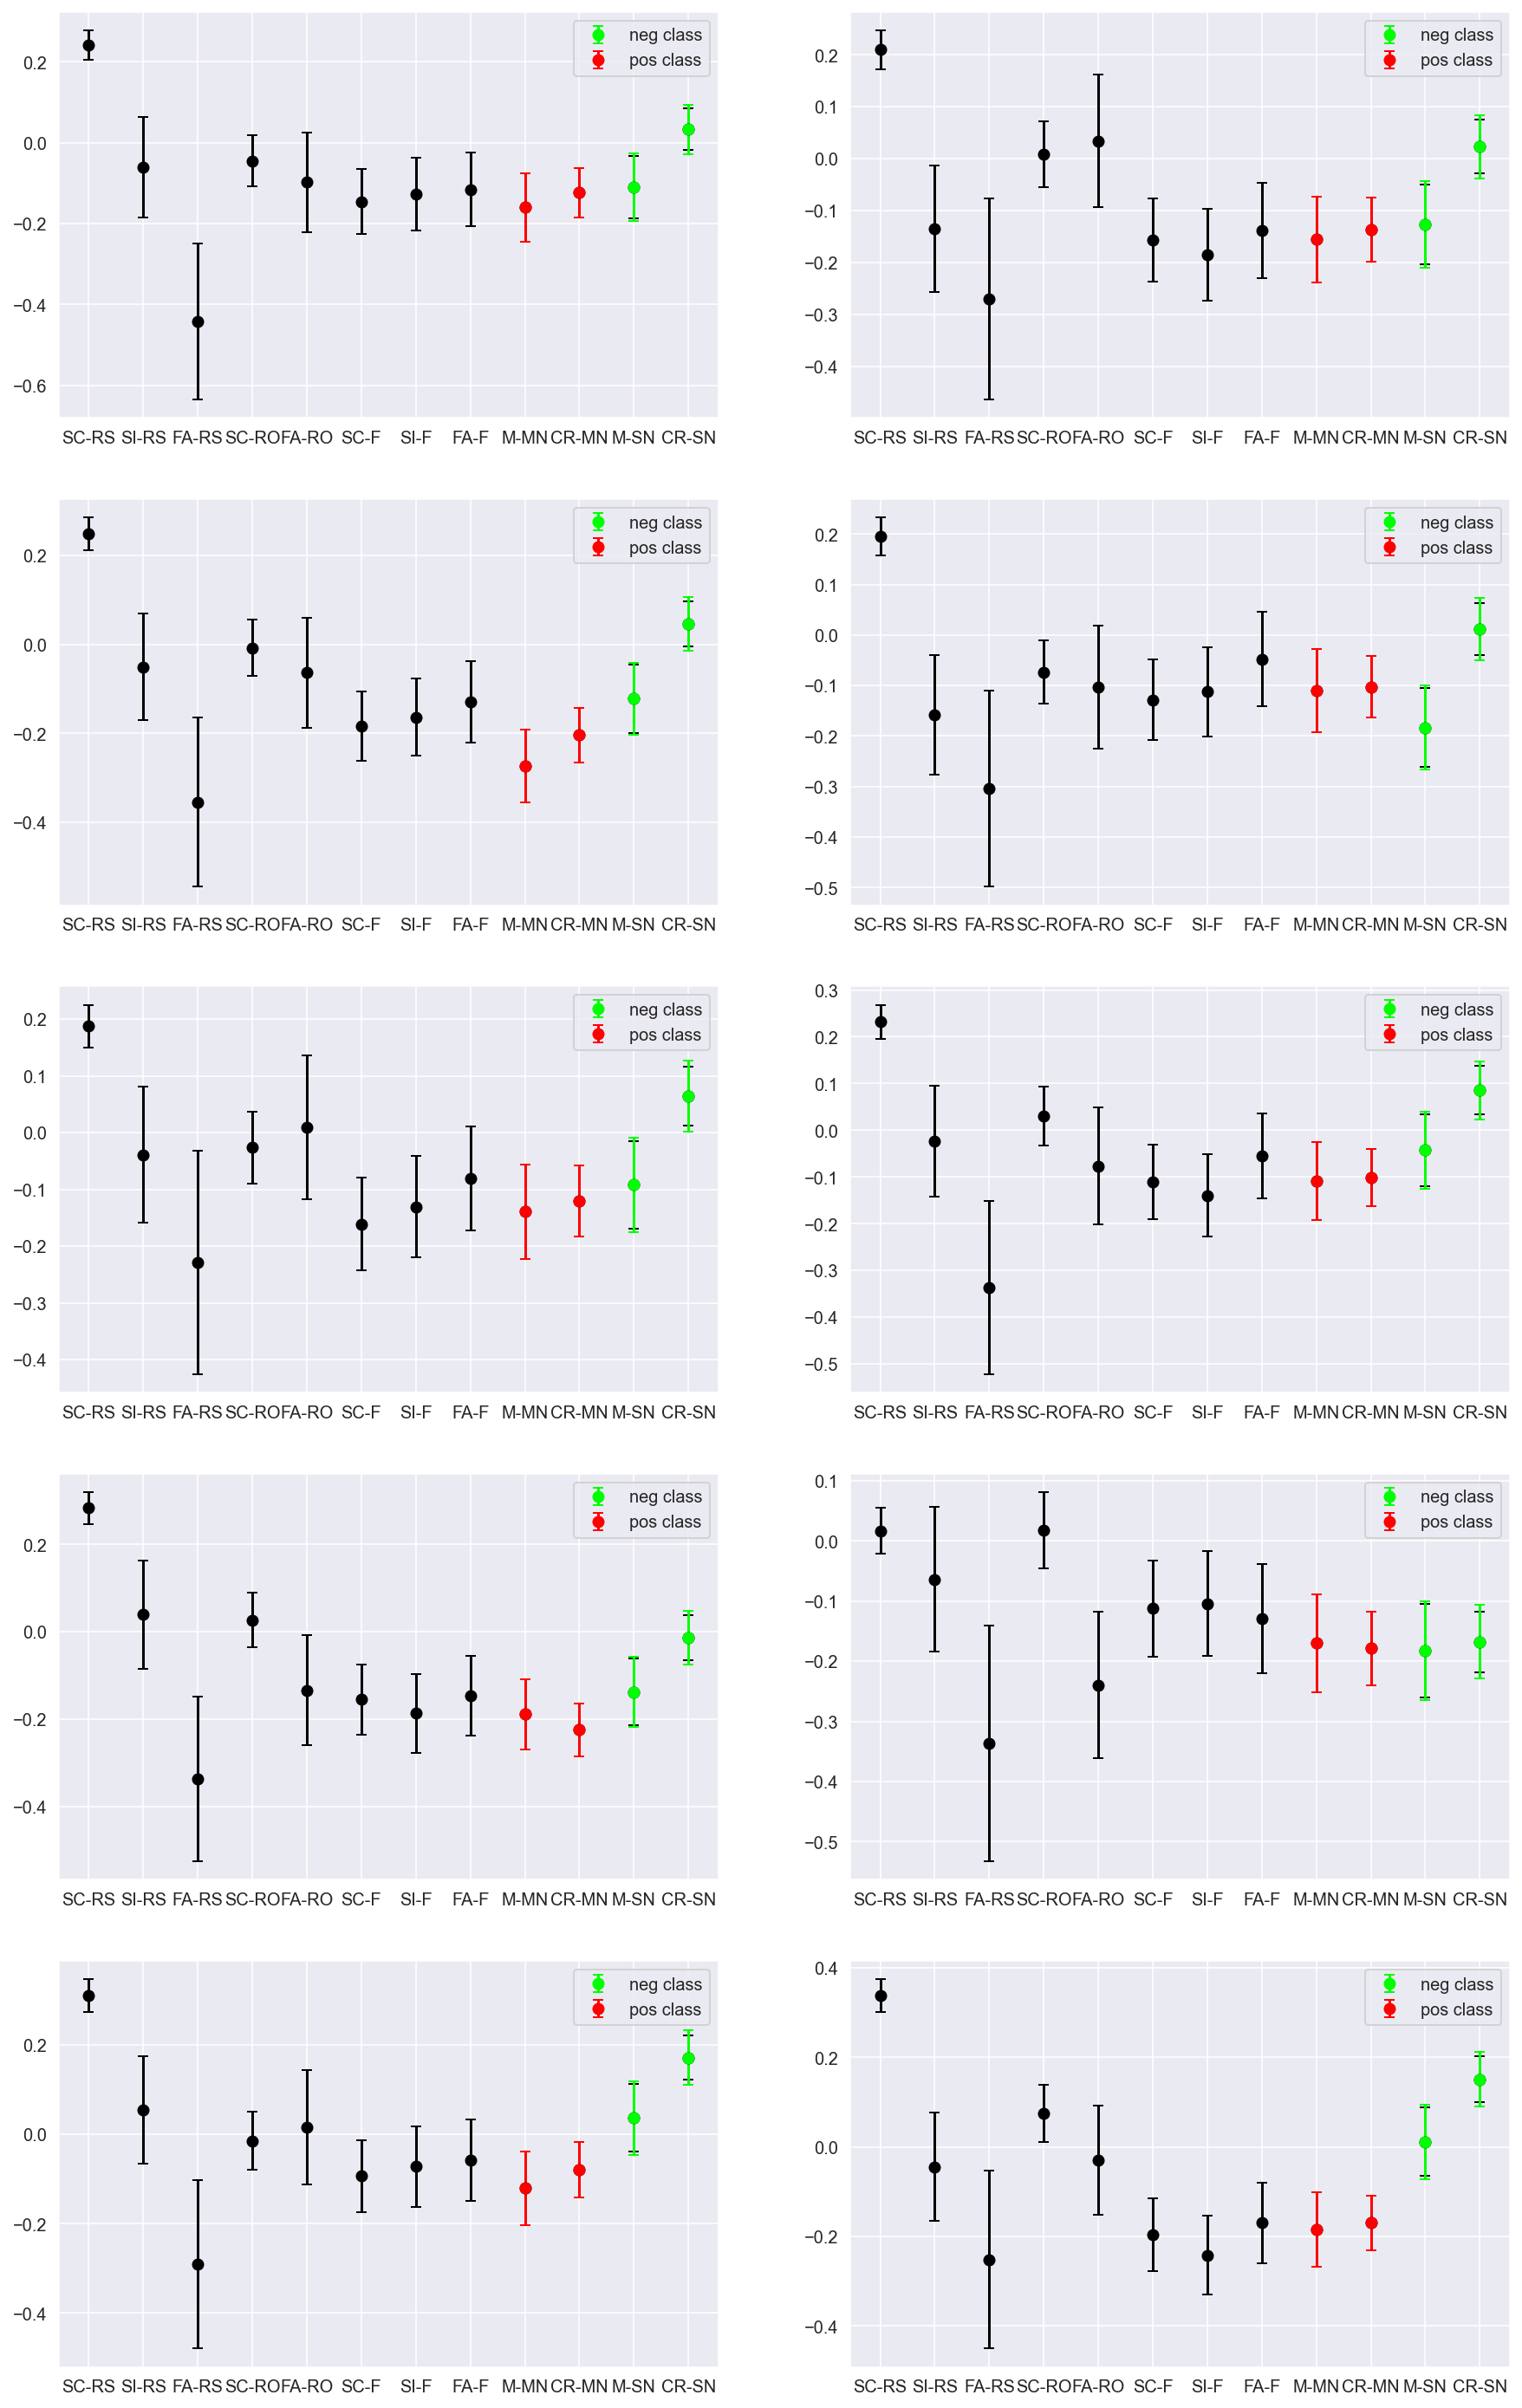

In [ ]:
# multiple group

file_path = "../../../EEG-Familiarity-Prediction/data_imbalLDA_1.mat"

data_preproc = preproc(file_path, experiment_num=1)
pos1, neg1 = data_preproc.filter_index(2,5,2,4)
pos2, neg2 = data_preproc.filter_index(4,5,4,4)

pos_idx, neg_idx = data_preproc.merge_two_class(pos1, neg1, pos2, neg2)
X, y, subject = data_preproc.get_data_by_index(pos_idx, neg_idx)

LDA = LinearDiscriminantAnalysis(shrinkage=None, solver="eigen")

pos_idx = [10, 11]
neg_idx = [8, 9]

fig, axs = plt.subplots(5,2, figsize=(15, 25))
axs = axs.flatten()

for _ in range(10):
    data_preproc.generate_projections(LDA, pos_idx, neg_idx, X, y, subject, balance=True, plt=axs[_])

In [ ]:
X

array([[ -7.23661128, -13.93739628, -22.81788437, ...,  -9.40298223,
        -11.77818306, -18.10076694],
       [ -2.63865315,   0.3358343 ,  -1.92867504, ...,  14.19302948,
          9.98168734,  17.5732571 ],
       [ -4.28406267,  -9.36639654, -16.71320915, ...,  -2.0318536 ,
         -3.8530683 ,   3.86939731],
       ...,
       [ -7.27156405,  -0.32252767,  -5.68846555, ...,  12.7781555 ,
          6.92138911,  14.37692222],
       [ -5.59509964,  -5.9680173 ,  -6.30330709, ...,   5.02529621,
         -1.2368217 ,   3.01240256],
       [ -6.08131518,  -4.03362041,  -1.15233776, ...,   7.00365166,
         11.0098844 ,   0.68450477]])

In [ ]:
show_doc(preproc.__init__)

---

### preproc.__init__

>      preproc.__init__ (file_path, experiment_num)

Initialize the Preprocessing module and load the appropriate dataset

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| file_path | str | file path to the matlab matrix data |
| experiment_num | int | denotes the experiement number |

In [ ]:
show_doc(preproc.filter_index)

---

### preproc.filter_index

>      preproc.filter_index (pos_source_label:int, pos_resp_label:int,
>                            neg_source_label:int, neg_resp_label:int)

A simplified version of prepare label. Instead of returns all the
dataset (X, y, group), this only returns a boolean array of the corresponding index
Since the data is in a nested array (in other words, 2-d array with different dim),
the returned element should also be a nested array.

The purpose of this is to prepared for multi-subclass merge for a single class preparation

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| pos_source_label | int | the positive class's source label.<br>for details, please refer to the above encodings |
| pos_resp_label | int | the positive class's response label |
| neg_source_label | int | the negative class's source label |
| neg_resp_label | int |  |
| **Returns** | **np.ndarray** | **the nested boolean array that indicates the location of<br>the positive class.** |

In [ ]:
show_doc(preproc.filter_index_single_class)

---

### preproc.filter_index_single_class

>      preproc.filter_index_single_class (source_label:int, resp_label:int,
>                                         include_left_out=True)

Variant of the above's filter_index. This method get out the indices of a 
specific class (single class indexer)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| source_label | int |  | source label.<br>for details, please refer to the above encodings |
| resp_label | int |  | response label |
| include_left_out | bool | True |  |
| **Returns** | **np.ndarray** |  | **the nested boolean array that indicates the location of<br>the positive class.** |

In [ ]:
show_doc(preproc.merge_two_class)

---

### preproc.merge_two_class

>      preproc.merge_two_class (pos1, neg1, pos2, neg2)

Apply logical OR to two positive class and two negative class
Purpose is to merge 1 and 2

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| pos1 | np.ndarray([Object]) | the positive class 1 index array |
| neg1 | np.ndarray([Object]) | the negative class 1 index array |
| pos2 | np.ndarray([Object]) | the positive class 2 index array |
| neg2 | np.ndarray([Object]) | the negative class 2 index array |
| **Returns** | **np.ndarray** | **the merged nested boolean array that indicates the location of<br>the positive class.** |

In [ ]:
show_doc(preproc.get_data_by_index)

---

### preproc.get_data_by_index

>      preproc.get_data_by_index (pos_idx, neg_idx, eliminate_trails=True)

given positive and negative index array, indexing out the
given data matrices and flattern them out

This will excluding the subject with
    10 or less trials on each class.

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| pos_idx | np.ndarray |  | the nested boolean array that indicates the position of the<br>positive class |
| neg_idx | np.ndarray |  | the nested boolean array that indicates the position of the<br>negative class |
| eliminate_trails | bool | True | whether we choose to leave out the participant with ten or less<br>class label |
| **Returns** | **np.ndarray** |  | **the input for the formatted flattern data** |

In [ ]:
show_doc(preproc.get_data_by_index_single_class)

---

### preproc.get_data_by_index_single_class

>      preproc.get_data_by_index_single_class (idx)

Variant of the aboves get_data_by_index, but with single class idx
given an index array, indexing out the
given data matrices and flattern them out

This will excluding the subject with
    10 or less trials on each class.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| idx | np.ndarray | the nested boolean array that indicates the position of the<br> desire class |
| **Returns** | **np.ndarray** | **the input for the formatted flattern data** |

In [ ]:
show_doc(preproc.get_data_by_participant)

---

### preproc.get_data_by_participant

>      preproc.get_data_by_participant (participant)

Given a participant's identifier (generated in the constructor),
index out the X for that corresponding participant.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| participant | int | id of the participant |
| **Returns** | **np.ndarray** | **the input for the formatted flattern data** |

In [ ]:
show_doc(preproc.generate_projections)

---

### preproc.generate_projections

>      preproc.generate_projections (clf, pos_idx, neg_idx, X, y, subject)

A function used to generate the projections based on the classifier
and according to different positive and negative classes.

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| clf | LinearDiscriminantAnalysis | the LDA classfier that is used to train the model |
| pos_idx | np.ndarray | the indecies for the positive classes on the projection graph |
| neg_idx | np.ndarray | the indecies for the negative classes on the projection graph |
| X | np.ndarray | the features of the dataset |
| y | np.ndaaray | the labels of the dataset |
| subject | np.ndarray | the subject index array |
| **Returns** | **A projection graph that projct the whole data of one complete participant (the participant is determined by LOSO)** |  |

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()